# Object Detection with YOLO library
Object detection not only tells what is in an image (image classification) but also tells where a given object is (object detection). The difference between object detection algorithms and classification algorithms is that in detection algorithms, we try to draw a bounding box around the object of interest to locate it within the image. <br>
The Region-based Convoluation Neural Network (R-CNN or Fast R-CNN or Faster R-CNN) will not be discussed in this file. We only demostrate the workflow for YOLOv3.<br>

The basic flow is:
1) load in pretrained YOLO weights and configuration file <br>
2) use DARKNET (the deep learning framework is written itself in C so it's fast. DARKNET & YOLO is a specialize framework and they are on top of the game in speed and accruacy). <br>
3) Preprocessing data with blobFromImage to perform scaling, resize, mean subtraction etc. <br> 
4) After prediction, we run Non-Max Suppression to output the bounding box with largest probability. <br>


In [1]:
# load library
import os
import cv2 
import time
import numpy as np 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

for dirname, _, filenames in os.walk('./'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        

./ObjectDetectionYolo.ipynb
./selective_search.ipynb
./.ipynb_checkpoints\ObjectDetectionYolo-checkpoint.ipynb
./.ipynb_checkpoints\selective_search-checkpoint.ipynb
./data\coco.names
./data\yolov3.cfg
./data\yolov3.weights
./images\BicubicOutput.png
./images\dog.jpg
./images\EDSR.png
./images\EdsrOutput.png
./images\giraffe.jpg
./images\IMG_6003.JPG
./images\input.png
./images\office.jpg
./images\original.png
./images\output.avi
./images\spartan.JPG
./images\test.jpg
./models\EDSR_x2.pb
./models\EDSR_x3.pb
./models\EDSR_x4.pb


**under /data, coco.names has all class of objects' name; yolov3.weights are the pretained weights; yolov3.cfg is the configuration file.**

In [2]:
names=open("./data/coco.names").read().strip().split("\n")

In [3]:
# here is the list of objects which we can detect based on YoloV3 
print(names)

['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


In [4]:
print(len(names))

80


In total, we have 80 classes of objects which can be detected with Yolo3 pretrained model <br>
Next, we need tell where the path for weights and configuration file

In [5]:
weights_path = './data/yolov3.weights'
configuration_path = './data/yolov3.cfg'

### Load YOLO object dectection function with CV2 dnn library

In [6]:
net = cv2.dnn.readNetFromDarknet(configuration_path,weights_path)

# Getting names of all layers
layers = net.getLayerNames()  # list of layers' names

print(layers)

('conv_0', 'bn_0', 'leaky_1', 'conv_1', 'bn_1', 'leaky_2', 'conv_2', 'bn_2', 'leaky_3', 'conv_3', 'bn_3', 'leaky_4', 'shortcut_4', 'conv_5', 'bn_5', 'leaky_6', 'conv_6', 'bn_6', 'leaky_7', 'conv_7', 'bn_7', 'leaky_8', 'shortcut_8', 'conv_9', 'bn_9', 'leaky_10', 'conv_10', 'bn_10', 'leaky_11', 'shortcut_11', 'conv_12', 'bn_12', 'leaky_13', 'conv_13', 'bn_13', 'leaky_14', 'conv_14', 'bn_14', 'leaky_15', 'shortcut_15', 'conv_16', 'bn_16', 'leaky_17', 'conv_17', 'bn_17', 'leaky_18', 'shortcut_18', 'conv_19', 'bn_19', 'leaky_20', 'conv_20', 'bn_20', 'leaky_21', 'shortcut_21', 'conv_22', 'bn_22', 'leaky_23', 'conv_23', 'bn_23', 'leaky_24', 'shortcut_24', 'conv_25', 'bn_25', 'leaky_26', 'conv_26', 'bn_26', 'leaky_27', 'shortcut_27', 'conv_28', 'bn_28', 'leaky_29', 'conv_29', 'bn_29', 'leaky_30', 'shortcut_30', 'conv_31', 'bn_31', 'leaky_32', 'conv_32', 'bn_32', 'leaky_33', 'shortcut_33', 'conv_34', 'bn_34', 'leaky_35', 'conv_35', 'bn_35', 'leaky_36', 'shortcut_36', 'conv_37', 'bn_37', 'leaky_

In [7]:
# We are searching for unconnected layers as output layers are not connected with any layer.
output_layers=[layers[i - 1] for i in net.getUnconnectedOutLayers()] 

print(output_layers)

['yolo_82', 'yolo_94', 'yolo_106']


### Load image

In [8]:
image=cv2.imread("./images/spartan.jpg")
image1=cv2.imread("./images/office.jpg")
print(image.shape)

(3024, 4032, 3)


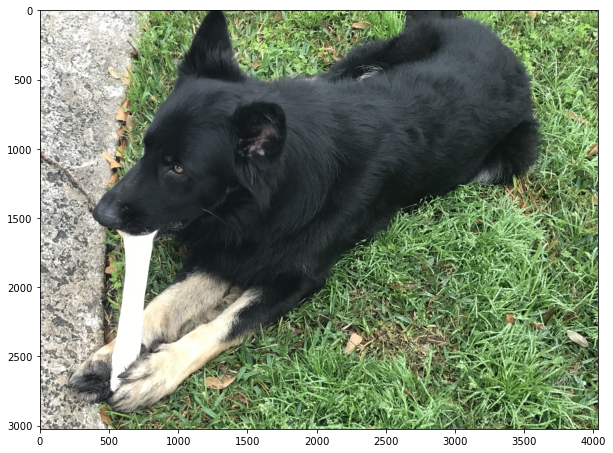

In [9]:
plt.figure(figsize = (10,10))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

### Use blobFromImage to prepare the image
* the size of image has to be dividable by 32. The reason for this will be described next.

In [10]:
# blobFromImage(image, scalefactor, size, swapRB, crop)
# scalefactor = 1/255.0 scales the pixels from [0,255] to [0,1]
blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (416,416), swapRB=True, crop=False)

# Check the output dimension
print(image.shape)  
print(blob.shape)  
# Resulted shape has number of images, number of channels, width and height

(3024, 4032, 3)
(1, 3, 416, 416)


(416, 416, 3)


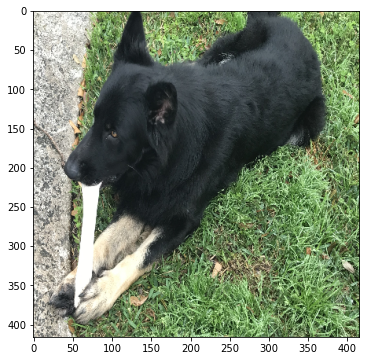

In [11]:
# Slicing blob and transposing to make channels come at the end
blob_to_show = blob[0, :, :, :].transpose(1, 2,0)
print(blob_to_show.shape) 

plt.figure(figsize=(6,6))
plt.imshow(blob_to_show)
plt.show()

In [13]:
# set up blob as the input to YOLO network
net.setInput(blob) 
t1=time.time()

# forward() function returns a nested list containing information about all the detected objects which includes the (x,y) 
# coordinates of the center of the object detected, height and width of the bounding box, confidence and scores for all the
# classes of objects listed in coco.names.
output = net.forward(output_layers)
t2 = time.time()

# Showing spent time for forward pass
print(t2-t1)

0.4009120464324951


### Output layer format of YOLOV3

The output layer of YOLOV3 is at layer yolo_82, yolo_94, and yolo_106. At each layer, the stride for each layer is 32, 16, and 8 coresspondingly. Therefore, for (416, 416) input image, at layer yolo_82, the output size is (13, 13) with stride of 32. at layer yolo_94, the output size is (26, 26) with stride of 16. at layer yolo_106, the output size is (52, 52) with stride of 8. That's why the input image size has to be dividable by 32. <br>
<br>
For layer yolo_82, it is responsible to detect large objects. For layer yolo_94, it is responsible to detect medium objects. For layer yolo_106, it is responsible to detect small objects. <br>
<br>
For YOLOV3, it predicts 3 bounding boxes for every cell. Therefore, for layer yolo_82, it has 13x13x3 = 507 bounding boxes. for layer yolo_94, it has 26x26x3 = 2028 bounding boxes. for layer yolo_106, it has 52x52x3 = 8112 bounding boxes. <br>
<br>
For each bounding box, it has 85 features output (bx, by, bw, bh, pc) + 80 coco.names classes. <br>

In [14]:
print(len(output[0])) # layer yolo_82
print(len(output[1])) # layer yolo_94
print(len(output[2])) # layer yolo_106
print(len(output[0][0])) # layer yolo_82 first bounding box output
print(len(output[1][0])) # layer yolo_94 first bounding box output
print(len(output[2][0])) # layer yolo_106 first bounding box output

507
2028
8112
85
85
85


In [15]:
Height = image.shape[0]
Width = image.shape[1]
print(Height, Width)

3024 4032


In [16]:
classes = []
confidences = []
boxes = []

In [17]:
# define parameters

probability_min = 0.5 # Setting minimum probability to eliminate weak predictions

threshold = 0.3 # Setting threshold for non maximum suppression

In [19]:
for out in output:
    for detected in out:
        scores = detected[5:]
        
        class_id = np.argmax(scores) # returning indices with max score and that would be our class as that will be 1 and rest will be 0
        if class_id > 0:
            print(detected[:4])
            print(detected[4])
            print(class_id)
            print(scores[class_id])
            print(detected[:4] * np.array([Width, Height, Width, Height]))

        # Getting the probability for current object by accessing the indices returned by argmax.
        confidence_current = scores[class_id]

        # Eliminating the weak predictions that is with minimum probability and this loop will only be encountered when an object will be there
        if confidence_current > probability_min:
            
            # Scaling bounding box coordinates to the initial image size
            # YOLO data format just keeps center of detected box and its width and height
            #that is why we are multiplying them elemwnt wise by width and height
            box = detected[0:4] * np.array([Width, Height, Width, Height])  #In the first 4 indices only contains 
            #the output consisting of the coordinates.
            
            # From current box with YOLO format getting top left corner coordinates
            # that are x and y
            x, y, w, h = box.astype('int')
            x = int(x - (w / 2))
            y = int(y - (h / 2))
            

            # Adding results into the lists
            boxes.append([x, y, int(w), int(h)]) 
            confidences.append(float(confidence_current)) 
            classes.append(class_id)         

[0.50809366 0.37532303 0.84188783 0.8088137 ]
0.94199663
16
0.4911647
[2048.6336174  1134.97683477 3394.49173737 2445.85260201]
[0.45002085 0.43797237 0.841274   0.89852583]
0.7545384
16
0.21354347
[1814.48406601 1324.42843723 3392.01686096 2717.14212227]
[0.5043981  0.438542   0.81290376 0.9096755 ]
0.9991904
16
0.6157693
[2033.73316956 1326.1510334  3277.62796783 2750.8586483 ]
[0.54974705 0.43789768 0.8682747  0.94097805]
0.9711609
16
0.64483833
[2216.58010483 1324.20259094 3500.88354492 2845.5176239 ]
[0.4495985  0.4712897  0.80687964 0.9212151 ]
0.6867244
16
0.21689661
[1812.78111649 1425.18003559 3253.33870697 2785.75451374]
[0.5068192  0.47178686 0.77936757 0.9226996 ]
0.9988626
16
0.6656382
[2043.49496841 1426.68345451 3142.41002655 2790.24350166]
[0.5514217  0.47567326 0.8231644  0.91548884]
0.9800838
16
0.644999
[2223.33230209 1438.43593311 3318.99887466 2768.43824959]


In [20]:
print(classes)

[16, 16, 16, 16, 16, 16, 16, 16]


In [21]:
print(boxes)

[[394, -49, 3277, 2750], [466, -98, 3500, 2845], [472, 31, 3142, 2790], [564, 54, 3318, 2768], [394, -49, 3277, 2750], [466, -98, 3500, 2845], [472, 31, 3142, 2790], [564, 54, 3318, 2768]]


In [22]:
print(confidences)

[0.6157693266868591, 0.6448383331298828, 0.6656382083892822, 0.6449990272521973, 0.6157693266868591, 0.6448383331298828, 0.6656382083892822, 0.6449990272521973]


In [23]:
results = cv2.dnn.NMSBoxes(boxes, confidences, probability_min, threshold)

# Showing labels of the detected objects
for i in range(len(classes)):
    print(names[int(classes[i])])

dog
dog
dog
dog
dog
dog
dog
dog


In [24]:
results

array([2])

### Non Max Supression to clean up the final predicted bounding boxes

In [25]:
colours = np.random.randint(0, 255, size=(len(names), 3)) 

print(colours.shape)
print(len(colours))
print(colours[0])  

(80, 3)
80
[237 158 203]


In [26]:
boxes

[[394, -49, 3277, 2750],
 [466, -98, 3500, 2845],
 [472, 31, 3142, 2790],
 [564, 54, 3318, 2768],
 [394, -49, 3277, 2750],
 [466, -98, 3500, 2845],
 [472, 31, 3142, 2790],
 [564, 54, 3318, 2768]]

In [27]:
image_cp = image.copy()

if len(results) > 0:
    for i in results.flatten():    
        print(i)
        # Getting current bounding box coordinates
        x, y, width, height = boxes[i][0], boxes[i][1], boxes[i][2], boxes[i][3]
        
        box_color = [int(j) for j in colours[classes[i]]]
        
        # Drawing bounding box on the original image
        cv2.rectangle(image_cp, (x, y), (x + width, y + height), box_color, 2)
            
        # Preparing text with label and confidence 
        text_box_current = '{}: {:.4f}'.format(names[int(classes[i])], confidences[i])

        # Putting text with label and confidence
        cv2.putText(image_cp, text_box_current, (x+2, y+20), cv2.FONT_HERSHEY_DUPLEX, 0.5,(0,0,0))
        
        

2


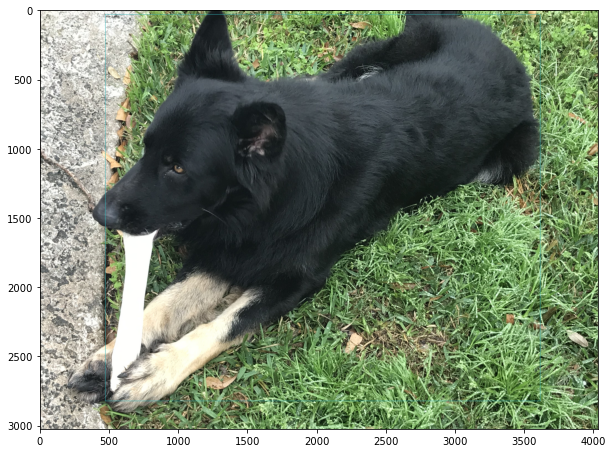

In [28]:
plt.figure(figsize = (10,10))
plt.imshow(cv2.cvtColor(image_cp, cv2.COLOR_BGR2RGB))
plt.show()